In [1]:
import os
 
import torch
from torch.utils.data import Dataset, DataLoader  # Pytorch의 데이터셋 관련
from torchvision import transforms  # 전처리모듈
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from tqdm import tqdm
from lxml import etree
from effdet import create_model

In [2]:
trainlist = [x for x in os.listdir('./xray-img/Astrophysics/Single_Default') if x.endswith('png')]
len(trainlist)

3300

In [3]:
testlist = [x for x in os.listdir('./xray-img/Astrophysics_val/Single_Default') if x.endswith('png')]
len(testlist)

680

In [4]:
for i in testlist:
    tree = etree.parse(f'./xray-img/Annotation/eval/Pascal/AstroPhysics/{i[:-4]}.xml')
    root = tree.getroot()
    for i in root.findall('object'):
        label = i.find('name').text
        print(i.find('object')) 
    break

None


In [5]:
DATA_DIR = './xray-img/Astrophysics/Single_Default'
## 1920 * 1080
## 640 * 360
transform = transforms.Compose(
    [   
        transforms.Resize((360,640)),
        transforms.PILToTensor(),  ## PIL.ToTensor 사용 ToTensor와는 다름.
                                    ## PIL의 Image 객체를 텐서화
        transforms.ConvertImageDtype(dtype=torch.float)  ## Image 텐서 타입 설정
    ]
    
)


In [6]:
## stasndard class x_rayDataset(Dataset):
class x_rayDataset(Dataset):
    def __init__(self, image_root, xml_root, transform=None):
        super().__init__()
        self.image_root = image_root
        self.xml_root = xml_root
        self.transform = transform

        self.flist = ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']
        self.class2idx = {name: idx+1 for idx, name in enumerate(self.flist)}
        self.class2idx["unknown"] = 0

        self.data = self._load_metadata()  # 이미지 경로와 XML 경로만 저장

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, xml_path = self.data[index]
        image = Image.open(img_path).convert("RGB")

        # XML 파싱
        boxes, labels = [], []
        tree = etree.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            label = obj.find('name').text
            label = label if label in self.flist else "unknown"
            bbox = obj.find('bndbox')
            # xmin = int(bbox.find('xmin').text)
            # ymin = int(bbox.find('ymin').text)
            # xmax = int(bbox.find('xmax').text)
            # ymax = int(bbox.find('ymax').text)
            xmin = int(bbox.find('xmin').text)//3
            ymin = int(bbox.find('ymin').text)//3
            xmax = int(bbox.find('xmax').text)//3
            ymax = int(bbox.find('ymax').text)//3
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class2idx[label])

        target = {
            "boxes": torch.FloatTensor(boxes),
            "labels": torch.LongTensor(labels)
        }

        if self.transform:
            image = self.transform(image)

        return image, target

    def _load_metadata(self):
        data = []
        for filenames in os.listdir(self.image_root):
            if not filenames.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(self.image_root, filenames)
            xml_path = os.path.join(self.xml_root, filenames[:-4] + ".xml")

            # if not os.path.exists(xml_path):
            #     continue  # 해당 XML이 없으면 스킵

            data.append((img_path, xml_path))
            # print(data)
        return data


In [7]:
trainDS = x_rayDataset(
    image_root='./xray-img/Astrophysics/Single_Default',
    ## train image 경로
    xml_root='./xray-img/Annotation/Train/Pascal/Astrophysics_SingleDefaultOnly',
    ## train xml 경로
    transform=transform
)
validDS = x_rayDataset(
    image_root='./xray-img/Astrophysics_val/Single_Default',
    ## test image 경로
    xml_root="./xray-img/Annotation/eval/Pascal/AstroPhysics",
    ## test xml 경로
    transform=transform
)



In [8]:
# # img, target = trainDS[0]
# print(len(img), target)

print(f'[trainDS] 개수 : {len(trainDS)}개 ')
print(f'[validDS] 개수  : {len(validDS)}개 ')

[trainDS] 개수 : 3300개 
[validDS] 개수  : 680개 


In [9]:
## 배치 데이터 생성 함수
## ---------------------------------------------------------
## 함수기능 : 개별 샘플을 미니배치로 결합하는 역할
## 함수이름 : collator
## 매개변수 : 배치크기
## 반환결과 : 배치크기만큼 연결된 데이터
## ---------------------------------------------------------
def collator(batch):
    return tuple(zip(*batch))

In [10]:
## 클래스 변환 Dict 생성
idx2class ={value:key for key, value in trainDS.class2idx.items()}
IDX_TO_CATEGORY = idx2class
print(IDX_TO_CATEGORY)
## 학습용 테스트용 데이터 확인
print(f'[trainDS] 개수 : {len(trainDS)}개 ')
print(f'[validDS] 개수  : {len(validDS)}개 ')
## 학습용 데이터셋에서 이미지 1개
imgTS, targetDict = trainDS[0]  ## <== __getitem__(indx)
print(imgTS.shape, targetDict.keys())

{1: 'Firecracker', 2: 'Hammer', 3: 'NailClippers', 4: 'Spanner', 5: 'Thinner', 6: 'ZippoOil', 0: 'unknown'}
[trainDS] 개수 : 3300개 
[validDS] 개수  : 680개 
torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])


torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (272, 125, 107, 67)


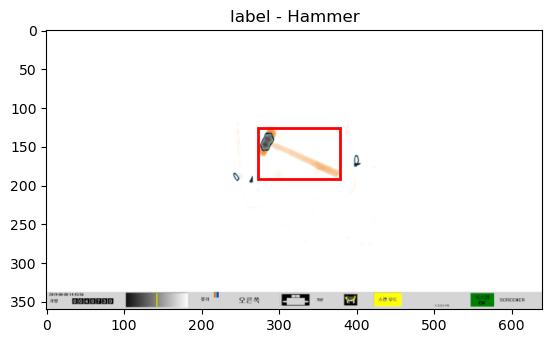

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (284, 112, 92, 92)


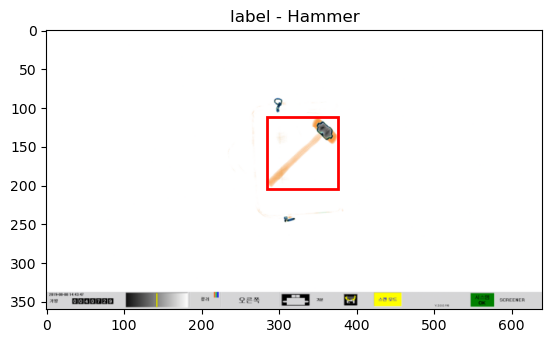

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (251, 112, 64, 107)


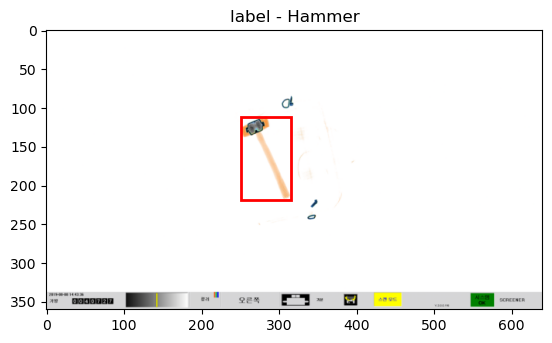

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (271, 125, 110, 45)


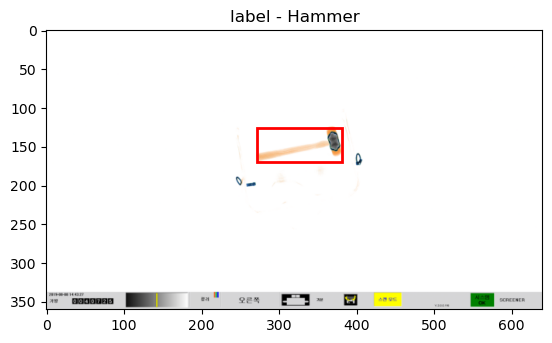

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (276, 125, 37, 81)


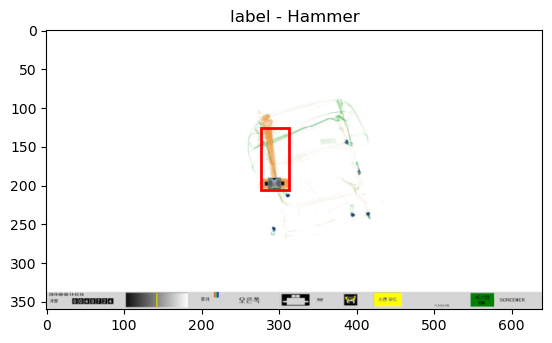

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (349, 139, 109, 59)


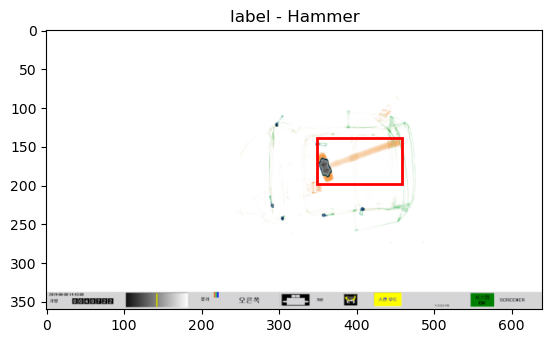

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (325, 132, 88, 94)


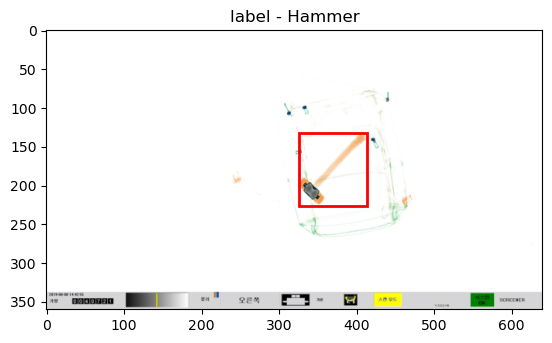

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (287, 127, 107, 68)


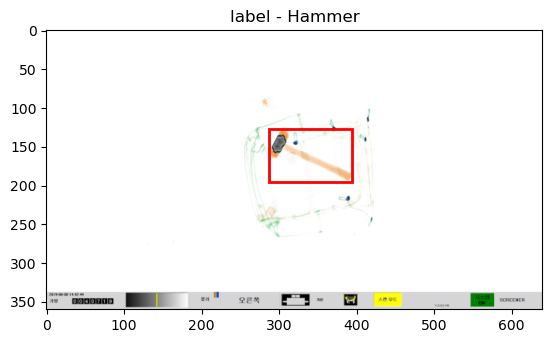

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (250, 116, 94, 86)


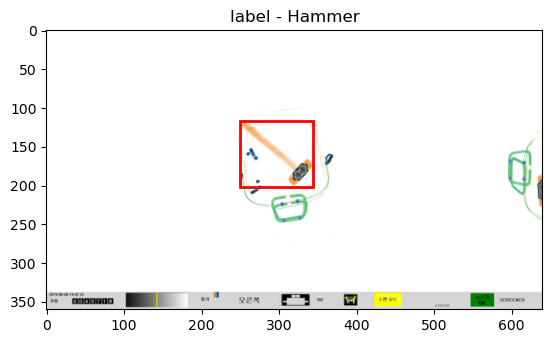

torch.Size([3, 360, 640]) dict_keys(['boxes', 'labels'])
lx, ly, w, h => (260, 186, 110, 43)


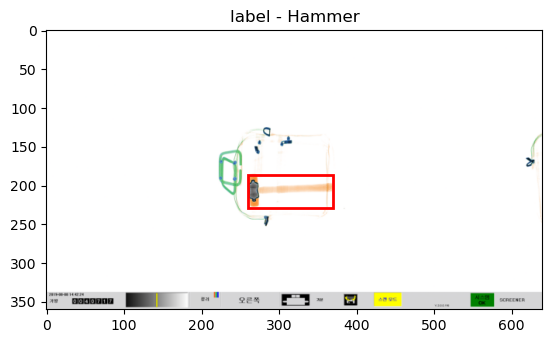

In [11]:
                             
for i in range(1210, 1220):
    imgTS, targetDict = trainDS[i]  ## <== __getitem__(indx)
    print(imgTS.shape, targetDict.keys())
    # - 라벨 정보 추출
    label = targetDict['labels'].item()

    # - 객체 위치 정보 추출
    lx, ly, rx, ry = [round(data.item()) for data in targetDict['boxes'].reshape(-1)]
    w, h = rx - lx, ry - ly

    print(f'lx, ly, w, h => {lx, ly, w, h}')
    ## 시각화 및 바운딩 박스
    plt.imshow(imgTS.permute(1, 2, 0))
    plt.title(f'label - {IDX_TO_CATEGORY[label]}')

    ## 바운딩 박스 추가
    ax = plt.gca()  #- get current axis
    ax.add_patch(patches.Rectangle((lx, ly), w, h, color='red', linewidth=2, fill=False))

    plt.show()

In [40]:

TBATCH_SIZE = 16
VBATCH_SIZE = 2
NUM_WORKER = 4

In [41]:
TRAIN_DL = DataLoader( trainDS, batch_size=TBATCH_SIZE, shuffle=True, drop_last=True, collate_fn=collator)
VALID_DL  = DataLoader( validDS,  batch_size=VBATCH_SIZE, shuffle=True, drop_last=True, collate_fn=collator)

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights, ResNet50_Weights


In [ ]:
from effdet import DetBenchTrain,DetBenchPredict,DetectionDatset
from torchvision import transforms as T

In [ ]:



dataset = DetectionDatset(

    transform=T.Compose([
    T.Resize((360, 640)),
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
])
)



In [ ]:
# weights 설정
WEIGHTS = RetinaNet_ResNet50_FPN_Weights.DEFAULT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# 모델 로딩 (pretrained backbone 포함)
MODEL = retinanet_resnet50_fpn(
    weights=None,  # 전체 모델은 초기화
    weights_backbone=ResNet50_Weights.DEFAULT,
    num_classes=7  # 여기서 원하는 클래스 수 지정
).to(DEVICE)

In [44]:
from torch import optim


params = [p for p in MODEL.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm  # tqdm 추가

In [46]:
## 학습 진행
for epoch in range(1):
    cost = 0.0
    total_accuracy_score = 0
    for idx, (images, targets) in enumerate(tqdm(TRAIN_DL, desc="Training", leave=False)):
        ## GPU에 이미지와 타겟 정보 위치
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        if idx == 4:
            break
        
        ## 모델 학습 ==> 이미지와 이미지 내의 객체 정보 ( 클래스, 박스) 전달
        ## - 객체 존재 여부 손실값
        loss_dict = MODEL(images, targets)
        ## - 모델 구성에서 계산된 손실값의 합계
        losses = sum(loss for loss in loss_dict.values())
        total_accuracy_score += accuracy_score(targets['label'],loss_dict['label'])
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        cost += losses

    lr_scheduler.step()
    cost = cost / len(TRAIN_DL)
    avg_accuracy_score = total_accuracy_score / len(TRAIN_DL)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}, Acc : {avg_accuracy_score:.3f}")

Training:   0%|          | 0/158 [00:00<?, ?it/s]

: 

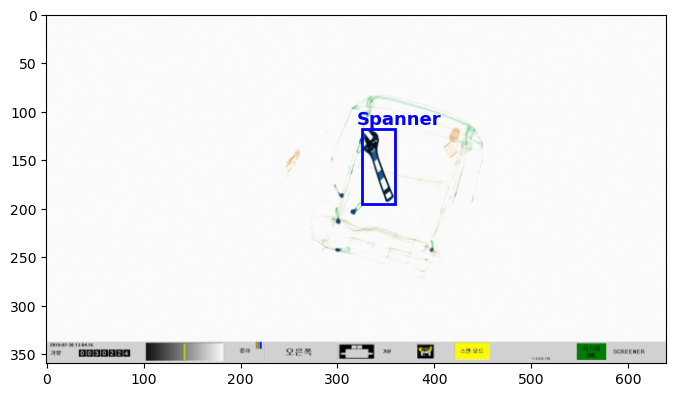

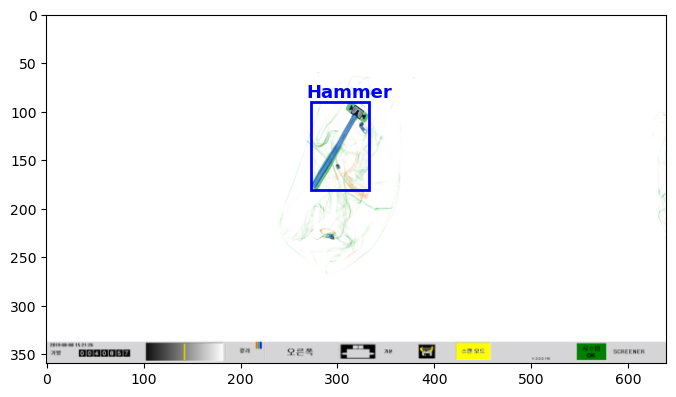

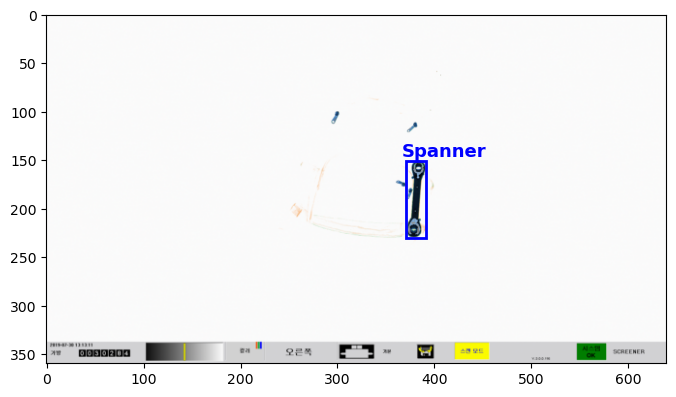

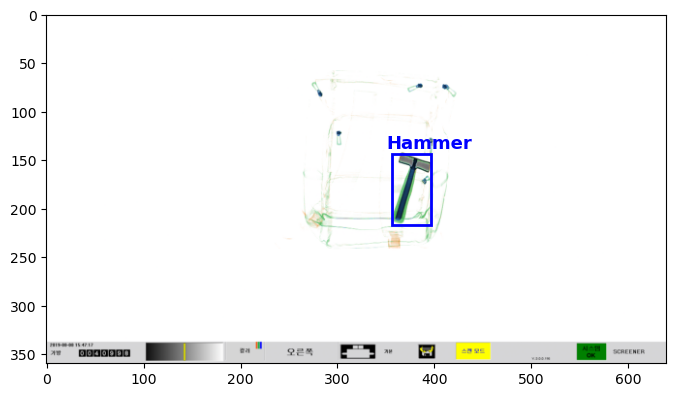

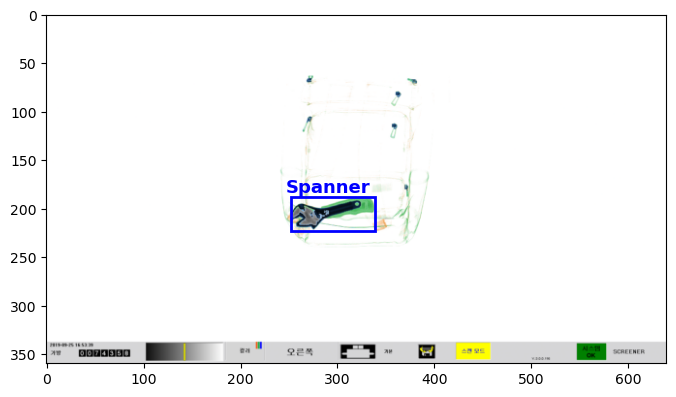

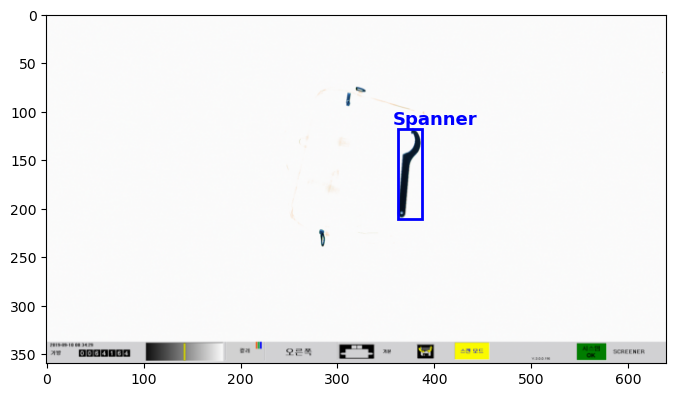

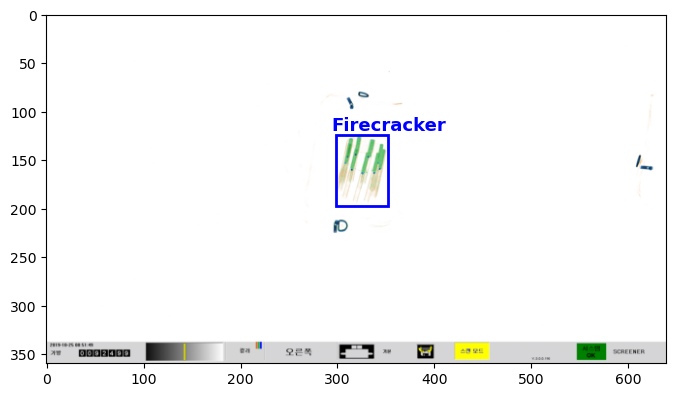

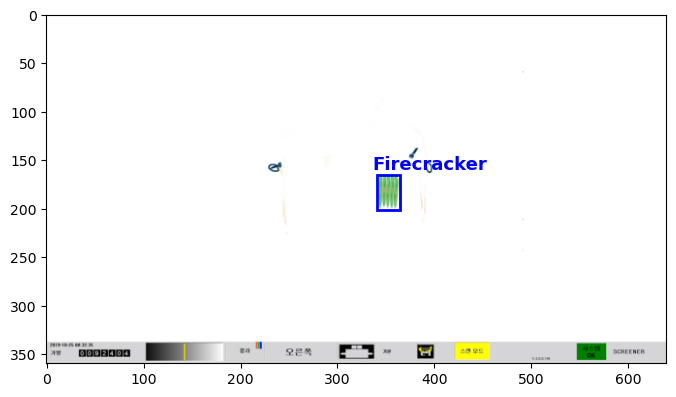

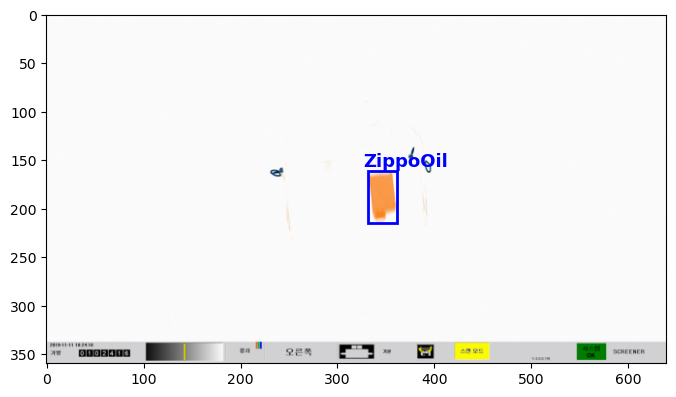

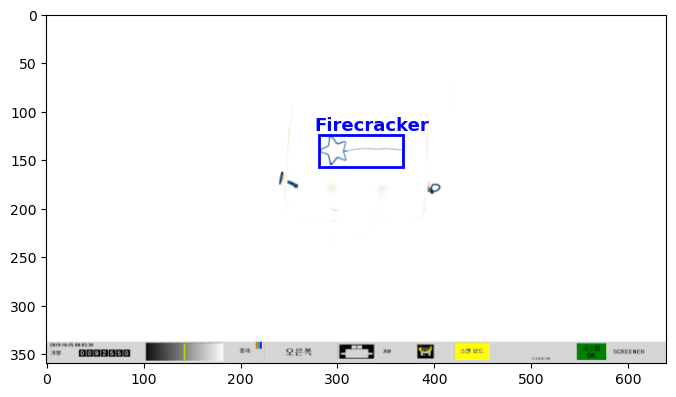

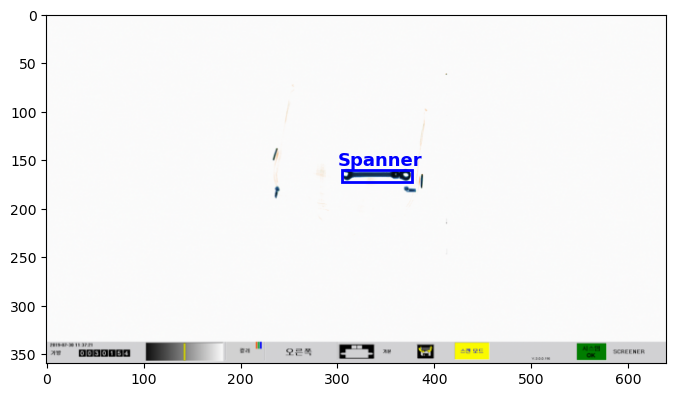

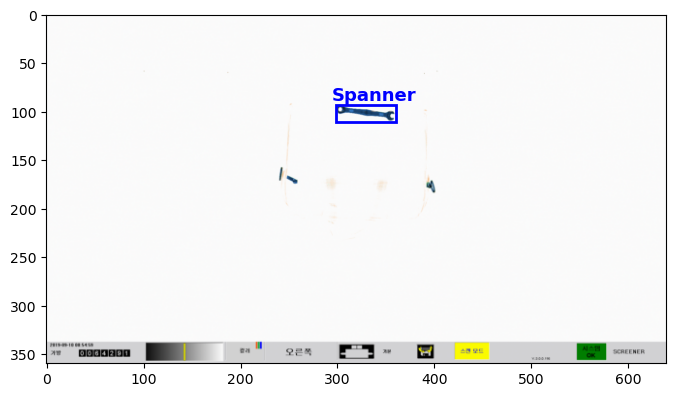

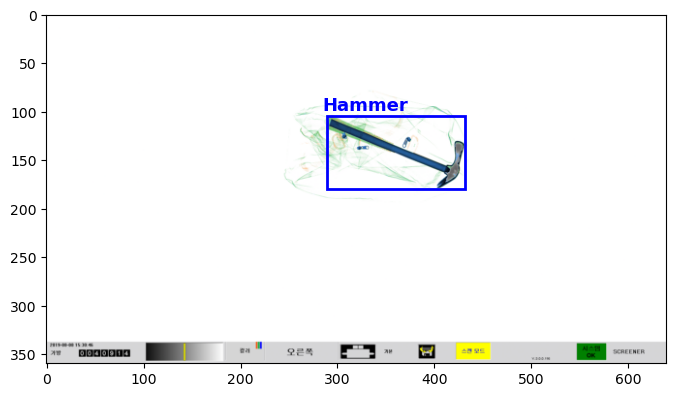

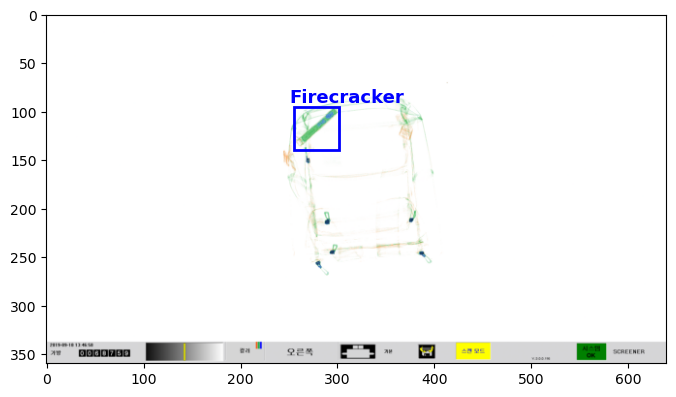

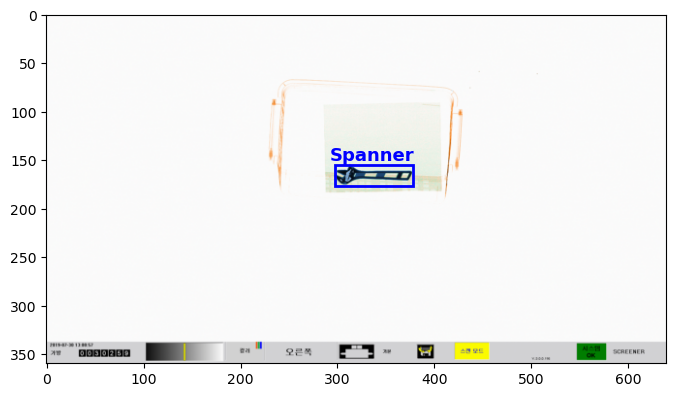

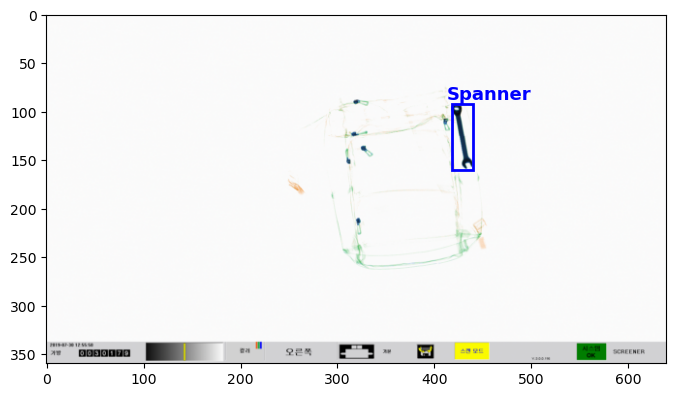

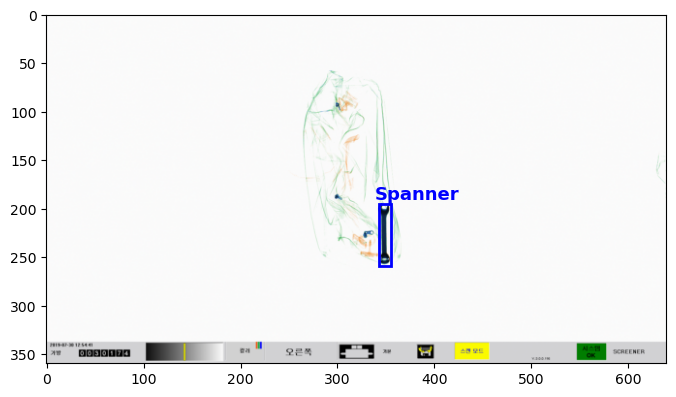

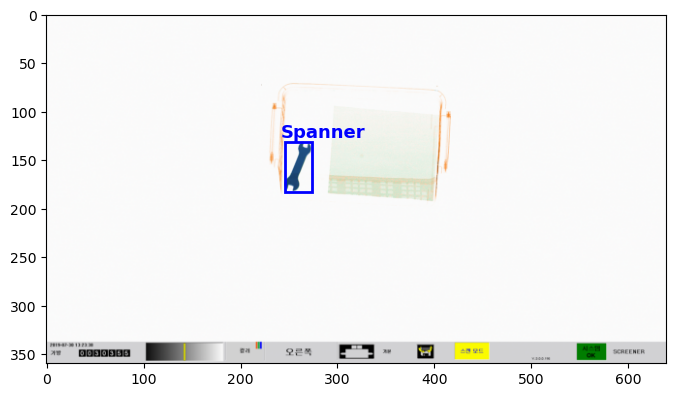

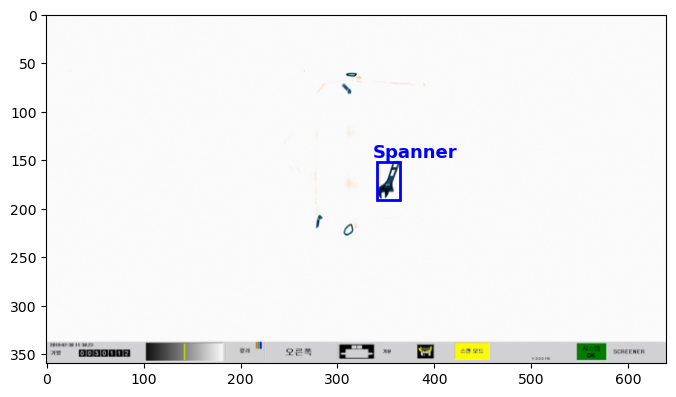

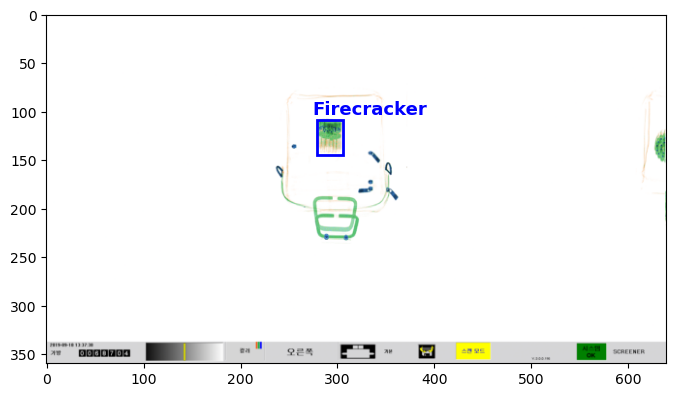

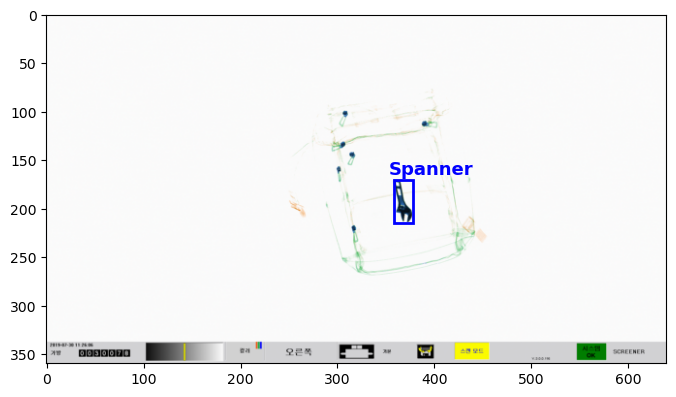

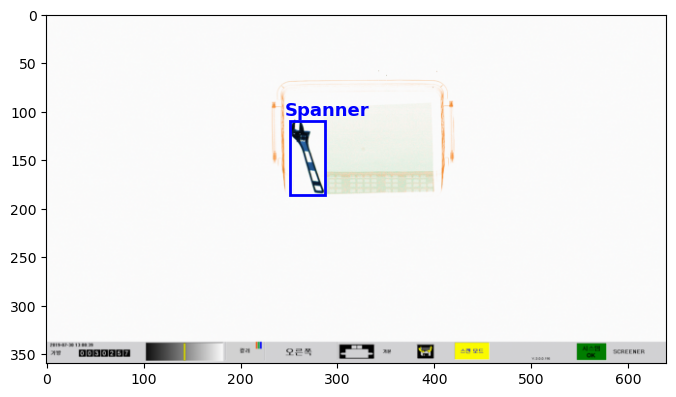

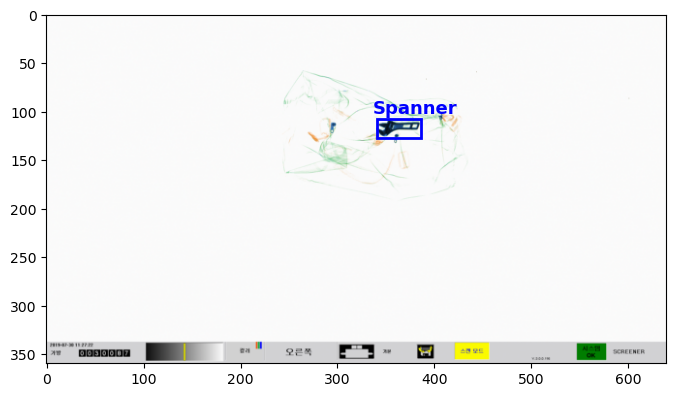

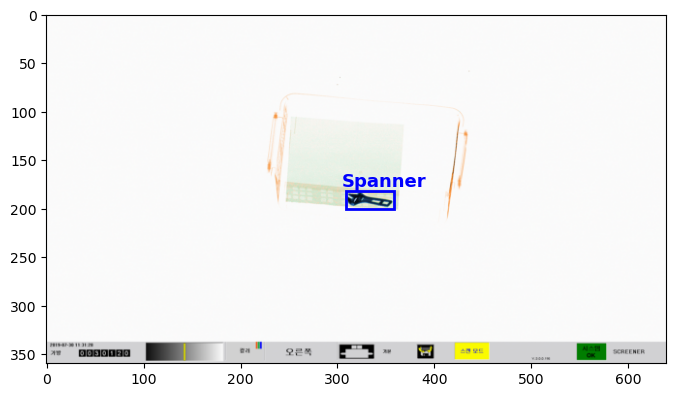

In [ ]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image

## 객체에 박스 그리기.
def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    #객체 위치에 라벨 달기
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )
 
 
## 검증진행
## 예측 결과에 대한 신뢰도. 0.5 이상이면 중간 이상의 신뢰도
threshold = 0.5
categories = IDX_TO_CATEGORY
with torch.no_grad():
    MODEL.eval()
    idx = 0
    for images, targets in VALID_DL:
        idx += 1
        if idx == 25:
            break
        # 예측진행
        images = [image.to(DEVICE) for image in images] ## GPU적용. cpu면 없어도됨
        
        outputs = MODEL(images)
        # 각 이미지에 대한 예측 결과 반환
        ## -> boxes : 예측된 경계상자 좌표
        ## -> labels: 예측 박스의 클래스 인덱스
        ## -> scores : 예측 박스에 대한 신뢰도(확률) 점수, 값의 범위는 0.0~1.0
        ## 예측 객체 위치, 라벨, 점수 저장 변수들
        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()
        
        
        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(to_pil_image(images[0]))

        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

        tboxes = targets[0]["boxes"].numpy()
        tlabels = targets[0]["labels"].numpy()
        for box, label in zip(tboxes, tlabels):
            draw_bbox(ax, box, f"{categories[label]}", "blue")
            
        plt.show()